# PCA: Examples and Observations

Principle Component Analysis (PCA) is one of the more complex concepts in data science. In this notebook, we look at some examples and make some general observations as to the (beneficial) effects and uses of PCA.

Working through the examples, observe:

 - Features that vary together appear in the same Principle Components. As a result, PCA solves the co-linearity problem. 
 - You can approximately reconstruct the original feature values with fewer than all the PCs.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def plotPCA(data, pca=None, num_components = None, idx = 0, feature_names = None):

    if pca is None:
        if num_components is None:
            pca = PCA()
        else:
            pca = PCA(n_components = num_components)
    
    X = pca.fit_transform(data)

    if num_components is None:
        num_components = pca.n_components_
    
    
    if isinstance(data, pd.DataFrame):
        x0 = data.iloc[idx,:]
    else:
        x0 = data[idx,:]
        
    x_pca = np.zeros_like(x0)
    
    coeffs = X[idx,:]
    
    if feature_names is None:
        try:
            feature_names = pca.feature_names_in_
        except:
            feature_names = [str(i) for i in range(data.shape[1])]

    C0 = 'goldenrod'
    C1 = 'dodgerblue'
    alpha = 0.6
    

    offset = 2
    num_cols = num_components + offset
    width_ratios = [1, 0.2] + [1]*num_components
        
    fig, ax = plt.subplots(2, num_cols, figsize = ((num_cols)*2, 8), 
                        sharex = True, sharey = False,
                        gridspec_kw = dict(width_ratios=width_ratios,
                                            hspace = 0.1, wspace = 0.1)                       
                        )
    
    if not np.all(np.isclose(pca.mean_, 0)):
        ax[0, 0].bar(feature_names, pca.mean_, color = C1, alpha = alpha)
        ax[0, 0].bar(feature_names, x0, color = C0, alpha = alpha)
        
        ax[0, 0].sharey(ax[1,offset])
    
    ax[0,0].set_title('Mean')

    ax[1, 0].bar(feature_names, x0-pca.mean_, color = C0, alpha = alpha)
    ax[1, 0].bar(feature_names, x_pca, color = C1, alpha = alpha)
    ax[1, 0].set_xlabel('Features - Mean = ', fontsize = 16)
    ax[1, 0].tick_params(axis='x', labelrotation = 90, )
    ax[1, 0].sharey(ax[1,offset])


    # ax[0, 2].set_title(f'PC1')   

    ax[0,1].set_visible(False)
    ax[1,1].set_visible(False)

    for r_idx, (r, coef) in enumerate(zip(pca.components_, coeffs)):
        x_pca += coef * r
        ax[0, r_idx+offset].bar(feature_names, r, color = C1, alpha = alpha)
        ax[0, r_idx+offset].text(0.5, 0.05, f'coef = {coef:0.2f}', ha = 'center', transform=ax[0, r_idx+offset].transAxes)
        
        ax[1, r_idx+offset].bar(feature_names, x0-pca.mean_, color = C0, alpha = alpha)
        ax[1, r_idx+offset].bar(feature_names, x_pca, alpha = alpha, color = C1)
        
        if r_idx == 0:
            ax_str = f'{coef:0.2f} * PC1'
        
        if r_idx>0:
            ax[0, r_idx+offset].sharey(ax[0,offset])
            ax[1, r_idx+offset].sharey(ax[1,offset])
            plt.setp(ax[0,r_idx+offset].get_yticklabels(), visible=False)
            plt.setp(ax[1,r_idx+offset].get_yticklabels(), visible=False)
            
            if coef > 0:
                ax_str = f' + {coef:4.2} * PC{r_idx+1}'
            elif coef < 0:
                ax_str = f' - {-1*coef:4.2} * PC{r_idx+1}'
            else:
                ax_str = f' + 0'
                        
        ax[0, r_idx+offset].set_title(f'PC{r_idx+1}')   
        ax[1, r_idx+offset].set_xlabel(ax_str, fontsize = 16)
        ax[1, r_idx+offset].tick_params(axis='x', labelrotation = 90, )


    ax[0,2].set_ylim([-1, 1])
    
    return pca, fig, ax
    
plt.show()



### Example 0: Synthetic data (boxes)

In [3]:
num_data = 100

boxes_dict = {'L_ft': 5*np.random.rand(num_data),
              'W_ft': 10*np.random.rand(num_data)
              }

boxes_df = pd.DataFrame(boxes_dict)
boxes_df

,L_ft,W_ft
0,0.103331,2.336030
1,4.044509,0.363975
2,3.626667,9.542177
3,4.338097,9.302513
4,3.474532,9.630789
...,...,...
95,1.466037,9.374146
96,4.284025,3.214741
97,0.265872,8.422860
98,3.516864,7.803655


In [4]:
boxes_df[['L_in', 'W_in']] = boxes_df[['L_ft','W_ft']]*12
boxes_df['P_ft'] = 2*(boxes_df['L_ft']+boxes_df['W_ft'])
boxes_df['P_in'] = 2*(boxes_df['L_in']+boxes_df['W_in'])

boxes_df


,L_ft,W_ft,L_in,W_in,P_ft,P_in
0,0.103331,2.336030,1.239974,28.032357,4.878722,58.544662
1,4.044509,0.363975,48.534103,4.367702,8.816967,105.803609
2,3.626667,9.542177,43.520000,114.506122,26.337687,316.052243
3,4.338097,9.302513,52.057170,111.630155,27.281221,327.374649
4,3.474532,9.630789,41.694383,115.569463,26.210641,314.527693
...,...,...,...,...,...,...
95,1.466037,9.374146,17.592438,112.489753,21.680365,260.164383
96,4.284025,3.214741,51.408300,38.576887,14.997531,179.970373
97,0.265872,8.422860,3.190468,101.074318,17.377464,208.529571
98,3.516864,7.803655,42.202370,93.643864,22.641039,271.692468


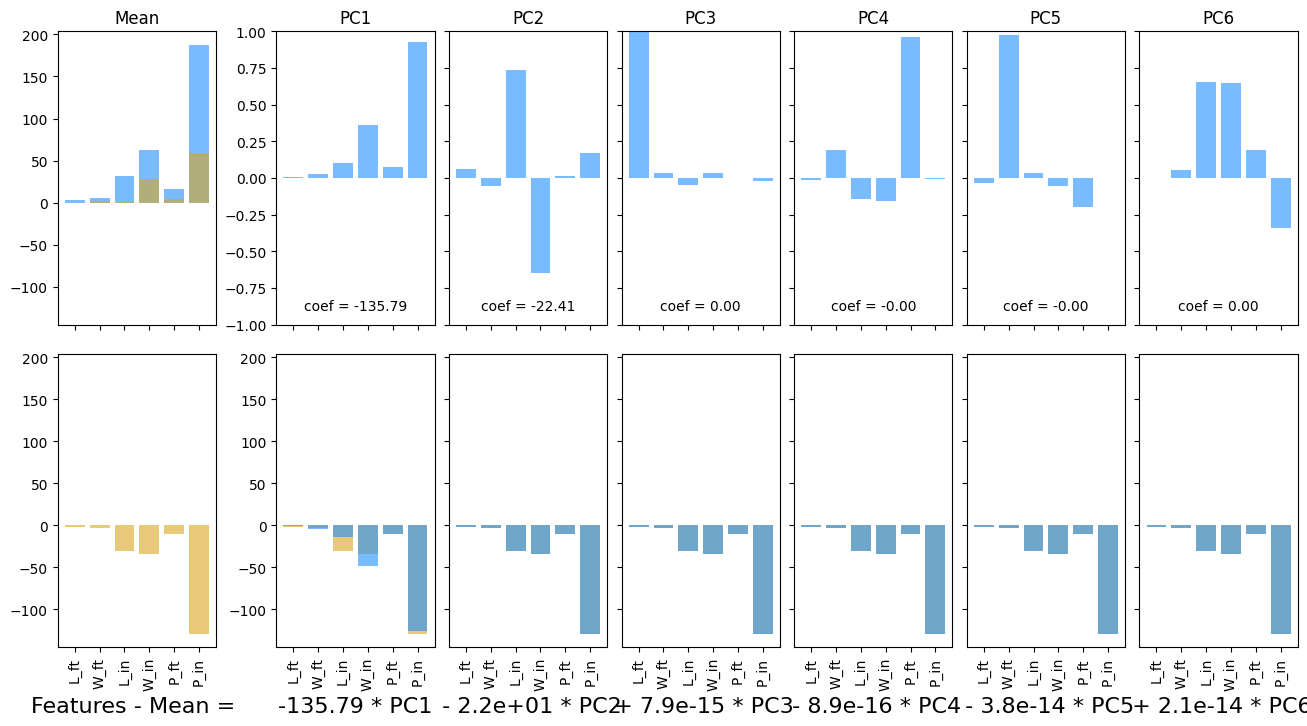

In [5]:
pca, fig, ax = plotPCA(boxes_df)
plt.show()

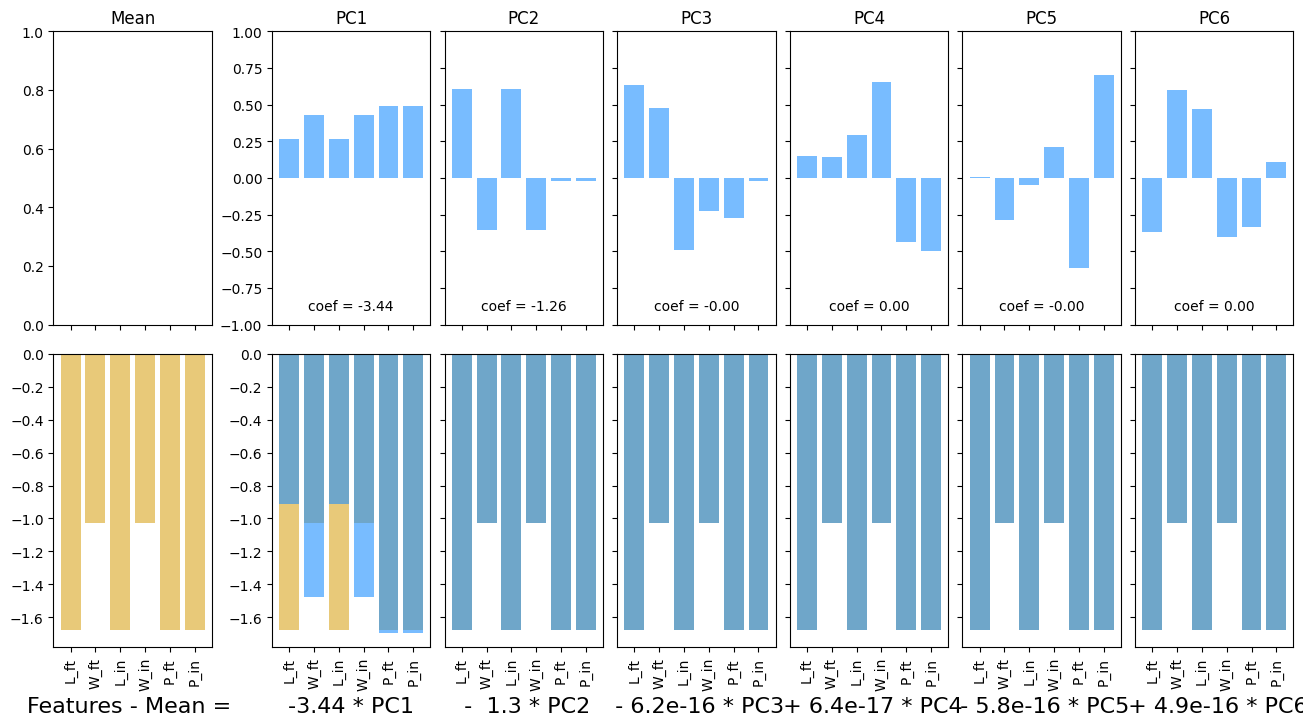

In [6]:
ss = StandardScaler()
boxes_scaled = ss.fit_transform(boxes_df)
boxes_scaled_df = pd.DataFrame(boxes_scaled, columns = boxes_df.columns)

pca_scaled, fig, ax = plotPCA(boxes_scaled_df)
plt.show()

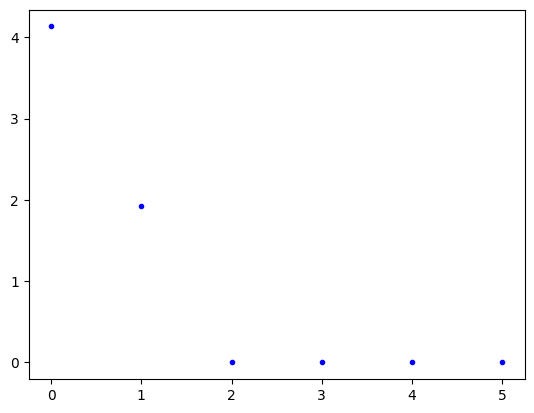

In [7]:
plt.plot(pca_scaled.explained_variance_, 'b.')
plt.show()

### Example 1: Macro-nutrients

In [8]:
macros_df = pd.read_csv('https://raw.githubusercontent.com/f-imp/Principal-Component-Analysis-PCA-over-3-datasets/refs/heads/master/datasets/Pizza.csv')
macros_df.head()

,brand,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,A,14016,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,A,14005,30.49,21.28,41.65,4.82,1.64,1.76,4.67


In [9]:
features_to_keep = ['mois', 'prot', 'fat', 'ash', 'sodium', 'carb', 'cal']

macros_df = macros_df[features_to_keep]
macros_df

,mois,prot,fat,ash,sodium,carb,cal
0,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,30.49,21.28,41.65,4.82,1.64,1.76,4.67
...,...,...,...,...,...,...,...
295,44.91,11.07,17.00,2.49,0.66,25.36,2.91
296,43.15,11.79,18.46,2.43,0.67,24.17,3.10
297,44.55,11.01,16.03,2.43,0.64,25.98,2.92
298,47.60,10.43,15.18,2.32,0.56,24.47,2.76


In [10]:
pca = PCA(n_components = 6)
macros_pca = pca.fit_transform(macros_df)

pca_df = pd.DataFrame(data = pca.components_, columns = macros_df.columns)
pca_df

,mois,prot,fat,ash,sodium,carb,cal
0,-0.276963,-0.266941,-0.278934,-0.055434,-0.011142,0.878084,-0.000603
1,0.747074,-0.055733,-0.657845,-0.040604,-0.023814,0.006818,-0.061254
2,-0.352016,0.809718,-0.467976,0.022225,-0.026245,-0.012469,-0.010062
3,-0.195900,-0.255747,-0.259802,0.871443,0.201453,-0.164525,-0.040678
4,0.059475,0.083719,0.035776,-0.166634,0.978316,0.057470,0.001497
5,0.440974,0.443490,0.448624,0.450220,-0.030463,0.444405,-0.080452


ValueError: too many values to unpack (expected 2)

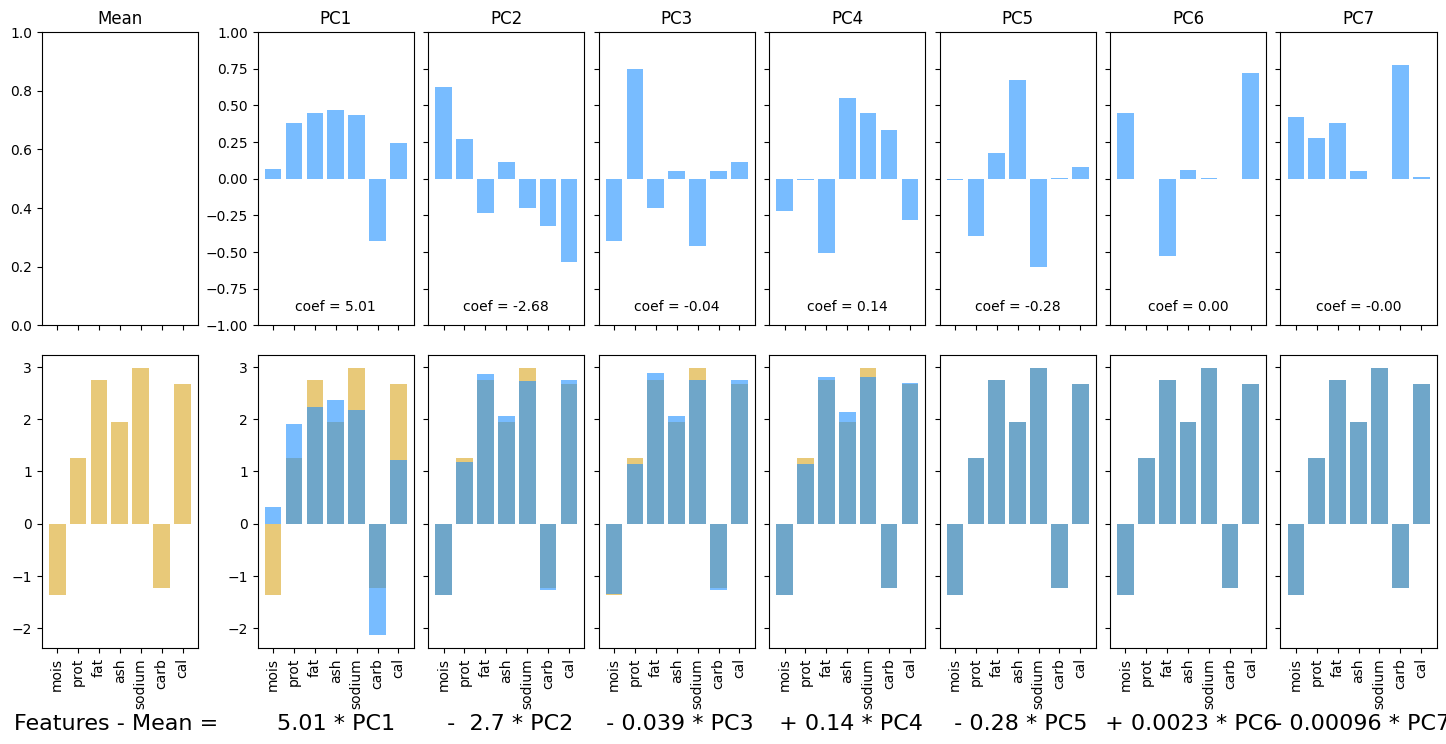

In [11]:
feature_names = list(macros_df.columns)
ss = StandardScaler()

X = ss.fit_transform(macros_df)
fig, ax = plotPCA(X, feature_names = feature_names)

### Example 2: Automobile specs

In [ ]:
cars_df = pd.read_csv('https://raw.githubusercontent.com/shreyamdg/automobile-data-set-analysis/refs/heads/master/cars.csv')
cars_df.head()

,Unnamed: 0,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,3,2,164,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,4,2,164,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [ ]:
specs_df = cars_df.select_dtypes(include = 'number').drop(columns = ['Unnamed: 0', 'symboling'])
names_df = cars_df[['make',  'num-of-doors', 'body-style', 'fuel-type']]

,make,num-of-doors,body-style,fuel-type
7,audi,four,wagon,gas


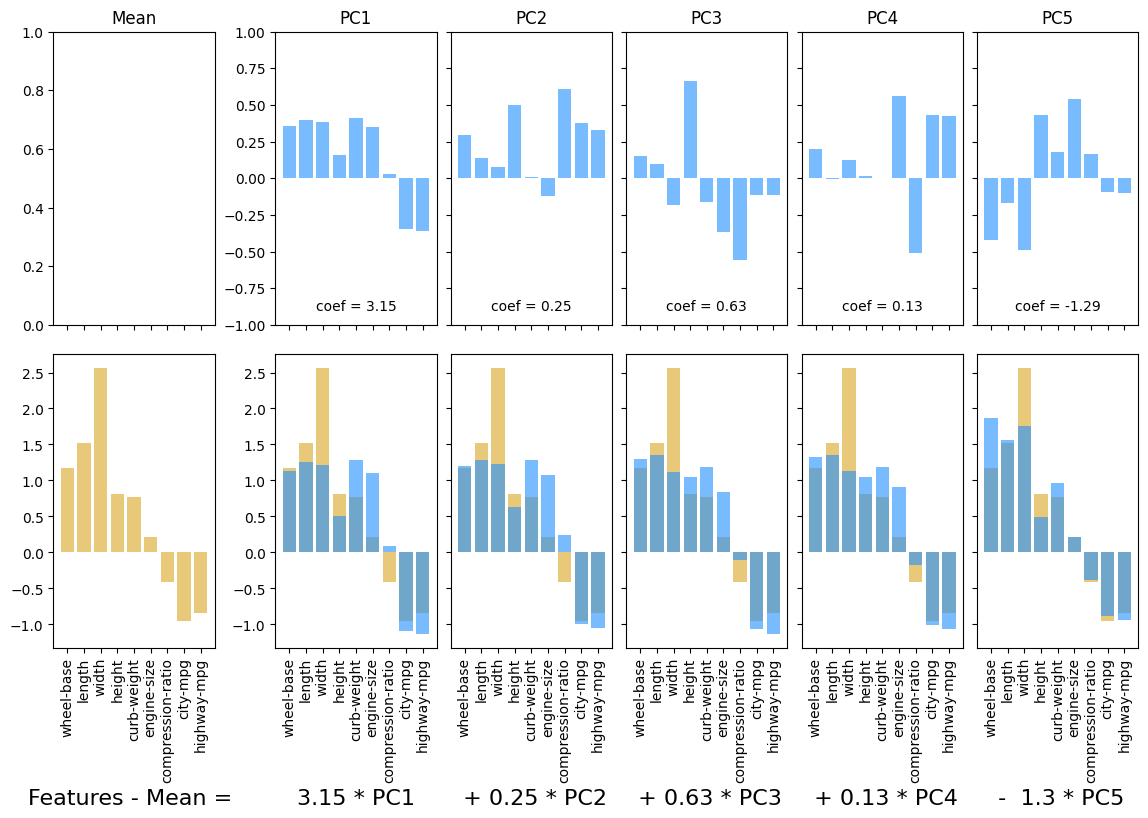

In [ ]:
idx = 7

ss = StandardScaler()
X = ss.fit_transform(specs_df)
feature_names = list(specs_df.columns)

display(names_df.iloc[[7]])

plotPCA(X, num_components = 5, feature_names = feature_names, idx = idx)
plt.show()